In [1]:
import torch
from torch import nn
from pytorch_lightning import LightningModule
import torchvision as tv
from torchvision import transforms
import torch.nn.functional as F
import torch.utils.data as data_utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

from collections import OrderedDict
from pytorch_lightning.loggers import WandbLogger
import wandb
import random

import warnings

In [2]:
from my_pgan import *

In [3]:
class PGAN(pl.LightningModule):
    def __init__(self, lr=0.1, latent_size=512, final_res=32, curr_res=4, k=1,
                 alpha=0.0, alpha_step=0.1, loss_f=WGANGP_loss,
                 normalize=True, activation_f=nn.LeakyReLU(negative_slope=0.2), 
                 device='cuda', normalize_img=True):

        super().__init__()
        self.save_hyperparameters(ignore=['activation_f', 'loss_f'])

        self.id=f"{random.random():.3f}"[2:]
        self.loss_f=loss_f
        self.generator=Generator(latent_size=latent_size, final_res=final_res, normalize=normalize, activation_f=activation_f, device=device)
        self.discriminator=Discriminator(latent_size=latent_size, final_res=final_res, normalize=normalize, activation_f=activation_f, device=device, normalize_img=normalize_img)

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch,  batch_idx, optimizer_idx):
      #  print(self.optimizers())

        xi, _=batch
        zi = torch.randn(xi.shape[0], self.hparams.latent_size) #TODO update zi sampling
        if self.hparams.normalize:
            zi=F.normalize(zi, dim=1, p=2)

        if optimizer_idx == 0: # train Generator
            g_loss=self.loss_f(self, zi=zi, net='generator')

            self.log("generator_loss", g_loss)
            self.log("curr_res", float(self.hparams.curr_res))
            self.log("alpha", float(self.hparams.alpha))
            return g_loss

        if optimizer_idx>0: # train discriminator
            d_loss=self.loss_f(self, zi=zi, xi=xi, net='discriminator')
            self.log("discriminator_loss", d_loss)
            self.log("alpha", float(self.hparams.alpha))
            self.log("curr_res", float(self.hparams.curr_res))
            return d_loss

    def configure_optimizers(self):
        decay=0
        if self.loss_f!=WGANGP_loss:
            decay=1e-4
        g_opt = torch.optim.Adam(self.generator.layers.parameters(), lr=self.hparams.lr, betas=(0,0.99), eps=1e-8, weight_decay=decay)
        d_opt = torch.optim.Adam(self.discriminator.layers.parameters(), lr=self.hparams.lr, betas=(0,0.99), eps=1e-8, weight_decay=decay)
        d_opt.add_param_group({'params': self.discriminator.decision_layer.parameters()})
        # should bne enough to load
        if self.generator.residual:
            g_opt.add_param_group({'params': self.generator.residual.model.parameters()})
            g_opt.add_param_group({'params': self.generator.residual.introduce.parameters()})
        if self.discriminator.residual:
            d_opt.add_param_group({'params': self.discriminator.residual.model.parameters()})
            d_opt.add_param_group({'params': self.discriminator.residual.introduce.parameters()})
        
        return [g_opt, d_opt]

    def optimizer_step(
            self,
            epoch,
            batch_idx,
            optimizer,
            optimizer_idx,
            optimizer_closure,
            on_tpu=False,
            using_native_amp=False,
            using_lbfgs=False,
        ):
        # update discrminator every step
        if optimizer_idx == 1:
            optimizer.step(closure=optimizer_closure)

        # update generator every k steps
        if optimizer_idx == 0:
            if (batch_idx + 1) % self.hparams.k == 0:
                # the closure (which includes the `training_step`) will be executed by `optimizer.step`
                optimizer.step(closure=optimizer_closure)
            else:
                # call the closure by itself to run `training_step` + `backward` without an optimizer step
                optimizer_closure()

    def save_generated_images(self, n=10, save_dir='./images/'):
        t=transforms.Compose([ transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.ToPILImage()])#, transforms.Resize(size=(256,256))])
        zi = torch.randn(n, self.hparams.latent_size)
        gen_imgs=self.generator(zi)
        i=0
        for img in gen_imgs: 
            t(img).save(save_dir+self.id+'_res_'+str(self.hparams.curr_res)+'_img_'+str(i)+'.png')
            i+=1
            
    def on_train_epoch_end(self):
        if self.current_epoch>int(0.5/self.hparams.alpha_step) or self.hparams.curr_res>4: # first run X epochs on 4x4
            if self.hparams.alpha==0 and self.hparams.curr_res<self.hparams.final_res:
                
                self.save_generated_images()
                
                self.hparams.curr_res*=2
              #  if self.hparams.curr_res==32:
                self.hparams.alpha_step*=0.75
                
                self.generator.add_scale(start_alpha=self.hparams.alpha_step)
                self.discriminator.add_scale(start_alpha=self.hparams.alpha_step)
                self.hparams.alpha+=self.hparams.alpha_step
                
                # update optimizers, 0-generator
                opts=self.optimizers()
                opts[0].add_param_group({'params': self.generator.residual.model.parameters()})
                opts[0].add_param_group({'params': self.generator.residual.introduce.parameters()})
                opts[1].add_param_group({'params': self.discriminator.residual.model.parameters()})
                opts[1].add_param_group({'params': self.discriminator.residual.introduce.parameters()})

               # print(model.generator.residual.model[1].module.weight.data[0,0])

            elif self.hparams.alpha>=1:
                self.generator.finish_adding_scale()
                self.discriminator.finish_adding_scale()
                self.hparams.alpha=0

                print("Done with: ", self.hparams.curr_res)
            elif self.hparams.alpha!=0:
                by=self.hparams.alpha_step
                self.generator.increase_alpha(by=by)
                self.discriminator.increase_alpha(by=by)
                self.hparams.alpha=min(self.hparams.alpha+by, 1.0)


In [4]:
class PGAN_loaded(PGAN):
    def __init__(self, lr=0.1, latent_size=512, final_res=32, curr_res=4, k=1,
                 alpha=0.0, alpha_step=0.1, loss_f=WGANGP_loss,
                 normalize=True, activation_f=nn.LeakyReLU(negative_slope=0.2),
                 device='cuda', normalize_img=True):

        super().__init__()
        self.save_hyperparameters(ignore=['activation_f', 'loss_f'])

        self.id=f"{random.random():.3f}"[2:]
        self.loss_f=loss_f
        self.generator=Generator(latent_size=latent_size, final_res=final_res, normalize=normalize, activation_f=activation_f, device=device)
        self.discriminator=Discriminator(latent_size=latent_size, final_res=final_res, normalize=normalize, activation_f=activation_f, device=device, normalize_img=normalize_img)
       
        resolution=8
        self.generator.add_scale(start_alpha=self.hparams.alpha)
        self.discriminator.add_scale(start_alpha=self.hparams.alpha)
        while self.hparams.curr_res>resolution:
            self.generator.finish_adding_scale()
            self.discriminator.finish_adding_scale()
       # warnings.warn("ONLY FOR LOADING 8X8 MODEL WITH ALPHA!=1")
            self.generator.add_scale(start_alpha=self.hparams.alpha)
            self.discriminator.add_scale(start_alpha=self.hparams.alpha)
            resolution*=2
        if
            
            

In [5]:
workers=8
batch_size=16

## creating and downloading data


In [6]:
data_train=DataLoader(tv.datasets.CIFAR10("../data/01_raw",transform=transforms.ToTensor(), download=True), batch_size=batch_size, num_workers=workers)
#data_val=DataLoader(tv.datasets.CIFAR10("../data/01_raw", transform=transforms.ToTensor() , train=False ), batch_size=batch_size, num_workers=workers)

In [7]:
oneclass_data=[]
for d in data_train:
    data, labels=d
  #  print(labels)
    for l in range(len(labels)):
        if labels[l]==0:
            oneclass_data.append(data[l].view(1,3,32,32))

In [8]:
oneclass_dataloader=DataLoader(data_utils.TensorDataset(torch.cat(oneclass_data, dim=0), torch.zeros(len(oneclass_data))),  batch_size=batch_size, num_workers=workers)

Load or create new

In [9]:
checkpoint = torch.load('epoch=1170-step=733046.ckpt')
print(checkpoint["hyper_parameters"])


{'lr': 0.0001, 'latent_size': 512, 'final_res': 32, 'curr_res': 32, 'k': 1, 'alpha': 0.3763125000000011, 'alpha_step': 0.0016875000000000002, 'normalize': True}


In [6]:
model = PGAN_loaded.load_from_checkpoint(
    checkpoint_path="epoch=499-step=313000.ckpt")
wandb.finish()
wandb_logger=None

RuntimeError: Error(s) in loading state_dict for PGAN_loaded:
	Missing key(s) in state_dict: "generator.layers.20.module.weight", "generator.layers.20.module.bias", "generator.residual.model.1.module.weight", "generator.residual.model.1.module.bias", "generator.residual.model.4.module.weight", "generator.residual.model.4.module.bias", "generator.residual.model.7.module.weight", "generator.residual.model.7.module.bias", "generator.residual.introduce.1.module.weight", "generator.residual.introduce.1.module.bias", "discriminator.layers.15.module.weight", "discriminator.layers.15.module.bias", "discriminator.layers.17.module.weight", "discriminator.layers.17.module.bias", "discriminator.residual.model.0.module.weight", "discriminator.residual.model.0.module.bias", "discriminator.residual.model.2.module.weight", "discriminator.residual.model.2.module.bias", "discriminator.residual.model.4.module.weight", "discriminator.residual.model.4.module.bias", "discriminator.residual.introduce.1.module.weight", "discriminator.residual.introduce.1.module.bias". 
	Unexpected key(s) in state_dict: "generator.layers.21.module.weight", "generator.layers.21.module.bias", "generator.layers.24.module.weight", "generator.layers.24.module.bias", "generator.layers.27.module.weight", "generator.layers.27.module.bias", "discriminator.layers.21.module.weight", "discriminator.layers.21.module.bias", "discriminator.layers.23.module.weight", "discriminator.layers.23.module.bias", "discriminator.layers.14.module.weight", "discriminator.layers.14.module.bias", "discriminator.layers.16.module.weight", "discriminator.layers.16.module.bias". 

In [11]:
wandb_logger = WandbLogger(project="PGAN",  name='locally_airplanes_continue_32' ,entity="dl_image_classification")

wandb: Currently logged in as: kpuchalskixiv (dl_image_classification). Use `wandb login --relogin` to force relogin


In [12]:
model.generator.device='cuda'
trainer = Trainer(gpus=1, max_epochs=600, log_every_n_steps=50, logger=wandb_logger)
trainer.fit(model, oneclass_dataloader)#, ckpt_path="epoch=1170-step=733046.ckpt")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 20.7 M
1 | discriminator | Discriminator | 20.7 M
------------------------------------------------
41.4 M    Trainable params
0         Non-trainable params
41.4 M    Total params
165.771   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

RuntimeError: DataLoader worker (pid(s) 96244, 90356) exited unexpectedly

In [35]:
model =  PGAN(lr=1e-4, latent_size=512, final_res=32, activation_f=nn.LeakyReLU(negative_slope=0.2), 
             alpha_step=4*1e-3, # 500 epochs on 4v4, 1k on both 8x8 and 16x16
             loss_f=WGANGP_loss)
wandb.finish()
wandb_logger=None

In [36]:
wandb_logger = WandbLogger(project="PGAN",  name='locally_WPGANPG_airplanes_3' ,entity="dl_image_classification")

wandb: Currently logged in as: kpuchalskixiv (dl_image_classification). Use `wandb login --relogin` to force relogin


In [ ]:
model.generator.device='cuda'
trainer = Trainer(gpus=1, max_epochs=2250+200, log_every_n_steps=50, logger=wandb_logger)
trainer.fit(model, oneclass_dataloader)#, ckpt_path="epoch=171-step=107672.ckpt")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 6.6 M 
1 | discriminator | Discriminator | 6.6 M 
------------------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.472    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Done with:  8
Done with:  16


In [38]:
model.current_epoch

1171

In [13]:
wandb.finish()

alpha,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
curr_res,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
discriminator_loss,█▆▄▅▇▇█▅▅▄▇▅▅▃▄▇▆▆▅▇▇▅▅▅▅▅▆▇▂▅▄▅▆▅▇▆▄▆▅▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
generator_loss,▅▄▅▃▄▅▅▅▆▇▃▇▄▆█▆▃█▅▄▅▅▆▃▅▆▆▇▆▄▅▄▅▅▄▅▄▅▇▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
alpha,0.93994
curr_res,32.0
discriminator_loss,-2.24519
epoch,334
generator_loss,0.85832


In [14]:
torch.save(model, 'local_airplanes_32.model')

# Debugging

In [20]:
model.generator.residual=None

In [26]:
latent_vec=F.normalize(torch.rand(40,512), p=2, dim=1)
latent_vec
model.generator.to('cpu')
model.generator.device='cpu'

In [ ]:
from torchvision.utils import save_image


In [13]:
model.hparams

"alpha":       0.05
"alpha_step":  0.05
"curr_res":    64
"final_res":   32
"k":           1
"latent_size": 512
"lr":          0.0001
"normalize":   True

torch.Size([3, 32, 32])


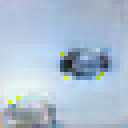

torch.Size([3, 32, 32])


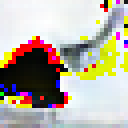

torch.Size([3, 32, 32])


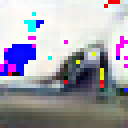

torch.Size([3, 32, 32])


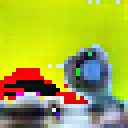

torch.Size([3, 32, 32])


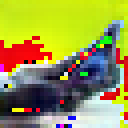

torch.Size([3, 32, 32])


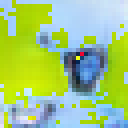

torch.Size([3, 32, 32])


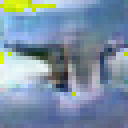

torch.Size([3, 32, 32])


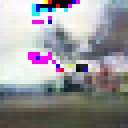

torch.Size([3, 32, 32])


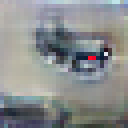

torch.Size([3, 32, 32])


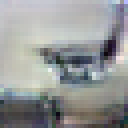

torch.Size([3, 32, 32])


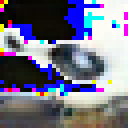

torch.Size([3, 32, 32])


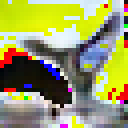

torch.Size([3, 32, 32])


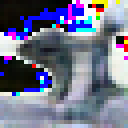

torch.Size([3, 32, 32])


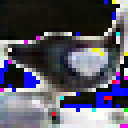

torch.Size([3, 32, 32])


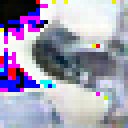

torch.Size([3, 32, 32])


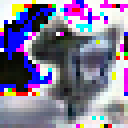

torch.Size([3, 32, 32])


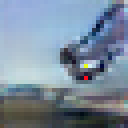

torch.Size([3, 32, 32])


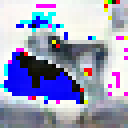

torch.Size([3, 32, 32])


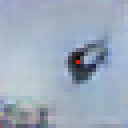

torch.Size([3, 32, 32])


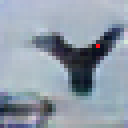

torch.Size([3, 32, 32])


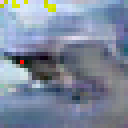

torch.Size([3, 32, 32])


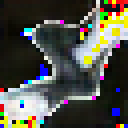

torch.Size([3, 32, 32])


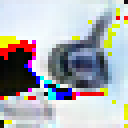

torch.Size([3, 32, 32])


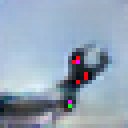

torch.Size([3, 32, 32])


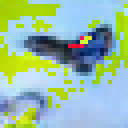

torch.Size([3, 32, 32])


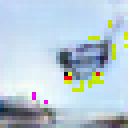

torch.Size([3, 32, 32])


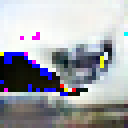

torch.Size([3, 32, 32])


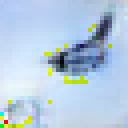

torch.Size([3, 32, 32])


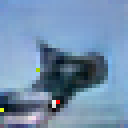

torch.Size([3, 32, 32])


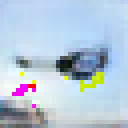

torch.Size([3, 32, 32])


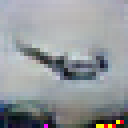

torch.Size([3, 32, 32])


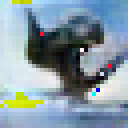

torch.Size([3, 32, 32])


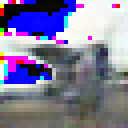

torch.Size([3, 32, 32])


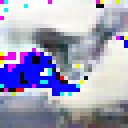

torch.Size([3, 32, 32])


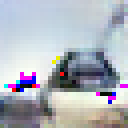

torch.Size([3, 32, 32])


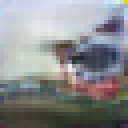

torch.Size([3, 32, 32])


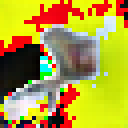

torch.Size([3, 32, 32])


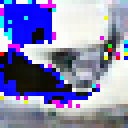

torch.Size([3, 32, 32])


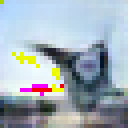

torch.Size([3, 32, 32])


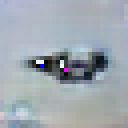

In [27]:

gen_imgs=model.generator(latent_vec)
i=0
t=transforms.Compose([  transforms.ToPILImage()])#, transforms.Resize(size=(256,256))])
for img in gen_imgs: 
   # imgs.append(t(img))
    print(img.shape)
    
    img_upsampled=(nn.Upsample(scale_factor=(4,4), mode='nearest')(img.view(1, 3, model.hparams.curr_res,model.hparams.curr_res)))[0]
    
   # print(img_upsampled)
   # t(img_upsampled).save("./images/plane"+str(i)+".png")
    display(t(img_upsampled))  
    


In [ ]:
for d in oneclass_dataloader: 
   # imgs.append(t(img))
    img=d[0][0]
    print(img.shape)
#    img+=1
 #   img -= img.min(1, keepdim=True)[0]
  #  img /= img.max(1, keepdim=True)[0]
    
    img_upsampled=(nn.Upsample(scale_factor=(4,4), mode='nearest')(img.view(1, 3, 32,32)))[0]
    print(img_upsampled)
    
  #  img_upsampled[0]=1.0
    display(t(img_upsampled)) 
    break

In [ ]:
img.min(0, keepdim=True)[0].shape

In [ ]:
img_upsampled[0]=1

In [ ]:
print(latent_vec.shape)
gen_imgs=model.generator(latent_vec)
(gen_imgs.shape)

In [ ]:
decision=model.discriminator(gen_imgs)
decision.shape

In [ ]:
 (decision ** 2).sum() * 1e-3

In [ ]:
(decision ** 2).flatten() == (decision[:, 0] ** 2)

In [ ]:
torch.mean(decision[:, 0])#.sum()

In [ ]:
#t=transforms.ToPILImage()
#imgs=[]
t=transforms.ToPILImage()
for img in gen_imgs: 
   # imgs.append(t(img))
    display(t(img))
#display(imgs[0]), display(imgs[1]), display(imgs[2]), display(imgs[3])

In [ ]:
#gen.finish_adding_scale()
gen.add_scale()
#gen.finish_adding_scale()
gen.layers

In [ ]:
#dis.finish_adding_scale()
dis.add_scale()
#dis.finish_adding_scale()
dis.layers

In [ ]:
print(latent_vec.shape)
gen_imgs=gen(latent_vec)
print(gen_imgs.shape)

In [ ]:
decision=dis(gen_imgs)
decision.shape, decision